In [1]:
# Google Earth Engine packages
import ee
import geemap

# other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# GIS packages
from pysheds.grid import Grid
import fiona

In [2]:
# initialize GEE at the beginning of session
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()         # authenticate when using GEE for the first time
    ee.Initialize()

In [3]:
# get config data
filename = 'output/srtm_gee.tif'
output_file = 'output/srtm_gee.shp'

y, x = 42.30029106, 78.09146228 # hydro new

In [4]:
# call map that centers aroung the region
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
"""
image = ee.Image('CGIAR/SRTM90_V4')
srtm_vis = { 'bands': 'elevation'}
#elevation = dataset.select('elevation')
#slope = ee.Terrain.slope(elevation)

Map.addLayer(image, srtm_vis, 'SRTM')
"""

In [7]:
image = ee.Image('USGS/SRTMGL1_003')
srtm_vis = { 'bands': 'elevation'}

Map.addLayer(image, srtm_vis, 'SRTM_NASA', True, 0.7)

In [12]:
image = ee.Image('MERIT/DEM/v1_0_3')
srtm_vis = { 'bands': 'dem',
             'min': -3,
             'max': 6000,
            'palette': ['000000', '478FCD', '86C58E', 'AFC35E', '8F7131','B78D4F', 'E2B8A6', 'FFFFFF']
           }
Map.addLayer(image, srtm_vis, 'MERIT DEM', True, 0.7)

In [13]:
point = ee.Geometry.Point(x,y)
Map.addLayer(point,{'color': 'blue'},'Discharge Point');

box = point.buffer(40000).bounds()
Map.addLayer(box,{'color': 'grey'},'Catchment Area', True, 0.7);
Map.centerObject(box, zoom=9)

In [ ]:
#feature = Map.draw_last_feature
#roi = feature.geometry()

In [ ]:
region = ee.Geometry.Polygon(
        [[[77.9818, 42.47152],
          [77.9818, 41.99486],
          [78.4801, 41.99486],
          [78.4801, 42.47152]]])
# add region to map
Map.addLayer(region, {}, 'Region')
Map.centerObject(region, zoom=9)

In [14]:
geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Python\matilda_edu\output\srtm_gee.tif


In [15]:


#Define a function to plot the digital elevation model
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent)
    plt.colorbar(label=label)
    plt.grid()

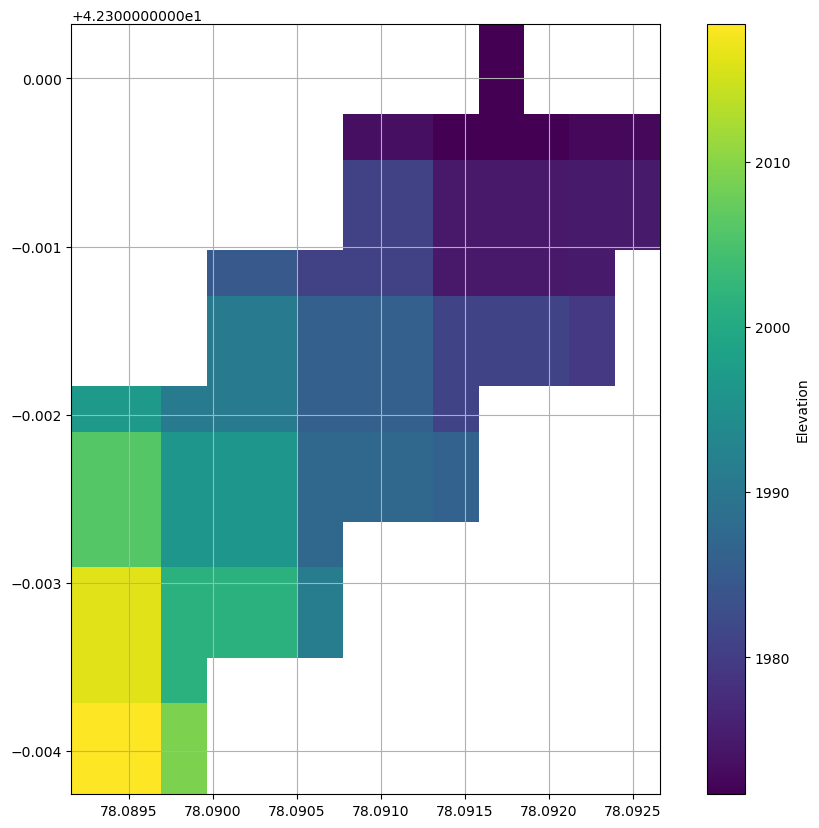

In [16]:
DEM_file = filename

# Plot the DEM
grid = Grid.from_raster(DEM_file)
dem = grid.read_raster(DEM_file)
grid.view(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Clip the DEM to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)


demView = grid.view(dem, nodata=np.nan)
plotFigure(demView,'Elevation')
plt.show()

In [17]:
## Create shapefile and save it
shapes = grid.polygonize()

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open(output_file, 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1


In [18]:
print("Mean catchment elevation is " + str(np.nanmean(demView)) + " m")

Mean catchment elevation is 1989.755 m
